In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pybatteryid import ModelStructure
from pybatteryid.model import load_from_file
from pybatteryid.plotter import plot_time_vs_current, plot_time_vs_voltage

from data import helper

### Example 1 - Model Identification for an NMC Battery

This file contains an example to identify battery models for a 1 Ah NMC battery. See [X] for more details.

#### A. Initialize model structure

In [2]:
# The LFP battery being modelled has the capacity around
# 1 Ah. The exact value has been calculated by coulomb-counting
# during GITT experiment.
battery_capacity = 3440.05372
# The experimental measurements were recorded with 1s
# sampling period.
sampling_period = 1

model_structure = ModelStructure(battery_capacity=battery_capacity, sampling_period=sampling_period)

#### B. Load EMF and Hysteresis data

In [3]:
#
emf_data = helper.load_npy_data('data/nmc/gitt_data.npy')
model_structure.add_emf_function(emf_data['soc_values'], emf_data['voltage_values'])

#### C. Add Basis Functions

In [4]:
model_structure.add_basis_functions(
    ['s⁻¹', 'log[s]', 's', 'exp[0.05sqrt[|i|]]', 'd[0.01,0.99]']
)

#### D. Load battery model

We load the identified battery model from a file.

In [5]:
model = load_from_file('results/nmc/model_n,l=1,1.npy')

#### E. Simulate output voltage

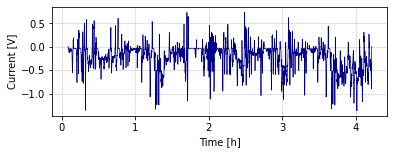

In [6]:
#
dataset = helper.load_npy_data(f'data/nmc/validation_data.npy')
#
plot_time_vs_current([(dataset['time'] / 3600, dataset['current'])],
                     units=('h', 'V'), colors=['darkblue'])

In [7]:
# To perform fair comparison, we provide same number of initial
# voltage values to each model. For example, the model with n=4
# requires four initial voltage values. If n=4 is the largest model
# order to be investigated, then we provide four initial values to
# all models, that is, n=1,2,3,4. Note that such consideration may not
# have significant impact on the comparison.
max_model_order = 4
#
voltage_simulated = model_structure.simulate(model, dataset, initial_soc=0.97973,
                                             no_of_initial_values=max_model_order)

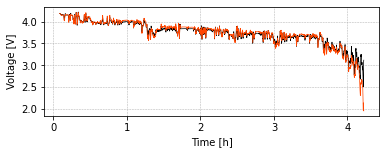

In [8]:
#
plot_time_vs_voltage([(dataset['time'] / 3600, dataset['voltage']), (dataset['time'] / 3600, voltage_simulated)],
                     units=('h', 'V'), colors=['k', 'orangered'])

#### F. Error Analysis

In [9]:
# We find error values for the whole region
rmse = mean_squared_error( voltage_simulated[max_model_order:], dataset['voltage'][max_model_order:], squared=False )
mae = mean_absolute_error( voltage_simulated[max_model_order:], dataset['voltage'][max_model_order:] )

print(f"The errors are given as: (RMSE, MAE) = ({rmse * 1e3} mV, {mae * 1e3} mV)")

The errors are given as: (RMSE, MAE) = (77.18419166124747 mV, 37.1038783101887 mV)
